In [2]:
import pandas as pd
import nltk
from sklearn.decomposition import NMF, LatentDirichletAllocation
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [3]:
with open("data.txt") as f_in:
    lines = [line.rstrip() for line in f_in] 
    lines = [line for line in lines if line] 

In [4]:
lemm =nltk.stem.WordNetLemmatizer()
from sklearn.feature_extraction.text import CountVectorizer
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [5]:
text = lines
tf_vectorizer = LemmaCountVectorizer(max_df=0.95,
                                    min_df=2,
                                    stop_words='english',
                                    decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)

In [8]:
lda = LatentDirichletAllocation(n_components=2, max_iter=100,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)

In [9]:
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=100, mean_change_tol=0.001,
             n_components=2, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [10]:
tf_feature_names = tf_vectorizer.get_feature_names()

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

class LemmaTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaTfidfVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

tfidf_vectorizer =LemmaTfidfVectorizer(max_df=0.95, min_df=2, stop_words='english',decode_error='ignore' )
tfidf = tfidf_vectorizer.fit_transform(text)

In [9]:
nmf = NMF(n_components=2,  max_iter=100, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')

In [10]:
nmf.fit(tfidf)

NMF(alpha=0.1, beta_loss='frobenius', init='nndsvd', l1_ratio=0.5,
  max_iter=100, n_components=2, random_state=1, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [11]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [12]:
## Method for Extraction of Words and Topics ##

def extract_words_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    topic_1_top_40_words = []
    topic_2_top_40_words = []
    
    for topic_idx, topic in enumerate(H):
        count = 0
        if topic_idx==0:
            topic_1_top_40_words = ([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])
            top_doc_indices_topic_1 = np.argsort( W[:,topic_idx] )[::-1][0:]  
        else:
            topic_2_top_40_words = ([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])
            top_doc_indices_topic_2 = np.argsort( W[:,topic_idx] )[::-1][0:]
            
    return top_doc_indices_topic_1,top_doc_indices_topic_2, topic_1_top_40_words, topic_2_top_40_words

In [13]:
lda_H = lda.components_
lda_W = lda.transform(tf)

In [14]:
## Extraction of Words and Topics (LDA) ##

_,_,lda_topic_1_top_40_words, lda_topic_2_top_40_words = extract_words_topics(lda_H, lda_W, tf_feature_names, text, 40, 3)

In [15]:
## Word Cloud (LDA) ##

print("-"*40)
print("LDA Top 40 words of Topic 1")
print("-"*40)
print()
print(lda_topic_1_top_40_words)
print()
lda_topic_1_top_words = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(lda_topic_1_top_40_words))
plt.imshow(lda_topic_1_top_words)
plt.axis('off')
plt.show()

----------------------------------------
LDA Top 40 words of Topic 1
----------------------------------------

['scotland', 'england', 'game', 'world', 'thiem', 'year', 'judge', 'set', 'work', 'long', 'ahead', 'shot', 'second', 'good', 'bairstow', 'morgan', 'test', 'case', 'certain', 'recommended', 'match', 'series', 'sent', 'took', 'sharif', 'say', 'run', 'bharati', 'appointment', 'lost', 'century', 'cup', 'number', 'cricket', 'seventh', 'decision', 'went', 'non', 'nation', 'court']



----------------------------------------
LDA Top 40 words of Topic 2
----------------------------------------

['minister', 'chief', 'congress', 'said', 'bjp', 'justice', 'set', 'thiem', 'party', 'new', 'playing', 'election', 'nadal', 'portfolio', 'kumaraswamy', 'court', 'play', 'important', 'game', 'issue', 'best', 'mukherjee', 'year', 'record', '2019', 'cup', 'davis', 'able', 'long', 'olympics', 'people', 'education', 'team', 'recommended', 'asian', 'won', 'win', 'format', 'lok', 'country']



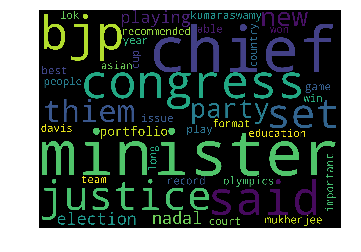

In [16]:
## Word Cloud (LDA) ##

print("-"*40)
print("LDA Top 40 words of Topic 2")
print("-"*40)
print()
print(lda_topic_2_top_40_words)
print()
lda_topic_2_top_words = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(lda_topic_2_top_40_words))
plt.imshow(lda_topic_2_top_words)
plt.axis('off')
plt.show()

In [17]:
nmf_H = nmf.components_
nmf_W = nmf.transform(tfidf)

In [18]:
## Extraction of Words and Topics (NMF) ##

top_doc_indices_topic_1, top_doc_indices_topic_2, nmf_topic_1_top_40_words, nmf_topic_2_top_40_words = extract_words_topics(nmf_H, nmf_W, tfidf_feature_names, text, 40, 3)

----------------------------------------
NMF Top 40 words of Topic 1
----------------------------------------

['minister', 'congress', 'bjp', 'chief', 'party', 'portfolio', 'said', 'kumaraswamy', 'jd', 'including', 'assembly', 'key', 'leader', 'devegowda', 'education', 'people', 'support', 'development', 'election', 'state', 'recommended', 'higher', 'certain', 'finance', 'justice', 'question', 'department', 'public', 'meant', 'issue', 'especially', 'constituency', 'maurya', 'bsp', 'mukherjee', 'new', 'court', 'home', 'till', 'case']



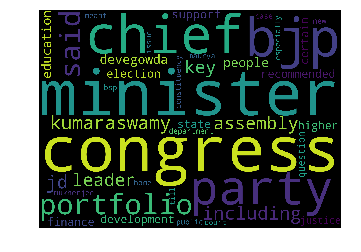

In [19]:
## Word Cloud (NMF) ##

print("-"*40)
print("NMF Top 40 words of Topic 1")
print("-"*40)
print()
print(nmf_topic_1_top_40_words)
print()
nmf_topic_1_top_words = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(nmf_topic_1_top_40_words))
plt.imshow(nmf_topic_1_top_words)
plt.axis('off')
plt.show()

----------------------------------------
NMF Top 40 words of Topic 2
----------------------------------------

['scotland', 'test', 'non', 'nation', 'england', 'fellow', 'year', 'cricket', 'cup', 'international', 'morgan', 'level', 'world', 'hope', 'decision', 'happened', 'saw', 'team', 'final', 'play', 'match', 'win', 'long', 'run', 'successive', 'century', 'came', 'batsman', 'lost', 'won', 'stand', 'best', 'ball', 'bairstow', 'home', 'today', 'thought', 'sharif', 'played', 'odi']



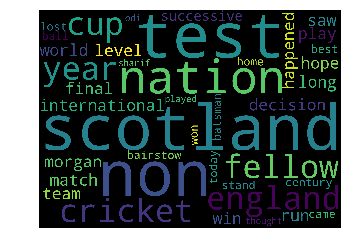

In [20]:
## Word Cloud (NMF) ##
print("-"*40)
print("NMF Top 40 words of Topic 2")
print("-"*40)
print()
print(nmf_topic_2_top_40_words)
print()
nmf_topic_2_top_words = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(nmf_topic_2_top_40_words))
plt.imshow(nmf_topic_2_top_words)
plt.axis('off')
plt.show()

In [21]:
########################################
# Postprocessing on NMF Document Score #
########################################

top_doc_indices_topic_1 = top_doc_indices_topic_1.tolist()
top_doc_indices_topic_2 = top_doc_indices_topic_2.tolist()
l = len(top_doc_indices_topic_1)

count = 0

for i in top_doc_indices_topic_1:
    top_doc_indices_topic_1_end_val = top_doc_indices_topic_1[l-1-count]
    
    if top_doc_indices_topic_2.index(i) >= top_doc_indices_topic_1.index(i):
        del top_doc_indices_topic_2[top_doc_indices_topic_2.index(i)]
    
    if top_doc_indices_topic_1.index(top_doc_indices_topic_1_end_val)>= top_doc_indices_topic_2.index(top_doc_indices_topic_1_end_val):
        del top_doc_indices_topic_1[top_doc_indices_topic_1.index(top_doc_indices_topic_1_end_val)]
    count += 1
    

In [22]:
print("-"*80)
print("Number of documents related to Topic 1 (After Postprocessing on NMF Document Score)")
print("-"*80)
print(len(top_doc_indices_topic_1))
print()
print("-"*80)
print("Number of documents related to Topic 2 (After Postprocessing on NMF Document Score)")
print("-"*80)
print(len(top_doc_indices_topic_2))

--------------------------------------------------------------------------------
Number of documents related to Topic 1 (After Postprocessing on NMF Document Score)
--------------------------------------------------------------------------------
27

--------------------------------------------------------------------------------
Number of documents related to Topic 2 (After Postprocessing on NMF Document Score)
--------------------------------------------------------------------------------
31


In [23]:
nmf_topic_1_sentences = []
nmf_topic_2_sentences = []
for doc_index in top_doc_indices_topic_1:
    nmf_topic_1_sentences.append(text[doc_index])
for doc_index in top_doc_indices_topic_2:
    nmf_topic_2_sentences.append(text[doc_index])

In [24]:
## All articles related to Topic 1 (using NMF) ##

print("-"*40)
print("All articles related to Topic 1 (using NMF)")
print("-"*40)
print('\n\n'.join('{}'.format(item) for item in nmf_topic_1_sentences))

----------------------------------------
All articles related to Topic 1 (using NMF)
----------------------------------------
The JD(S) leader became the chief minister after the Congress offered support to the party keep out the BJP. In the 225-member Assembly, including one nominated, the Congress has 78 MLAs, the JDS has 36 and the BJP 104, with three others.

Kumaraswamy retained the key Finance department, as also Energy with him while giving Home to his deputy G Parameshwara of the Congress. The chief minister had inducted 25 new ministers on June 6, including those from his party JD(S), Congress, BSP, and the fledgling KPJP.

Bengaluru: "What have I studied? I'm working as the chief minister" - this was Karnataka Chief Minister H D Kumaraswamy response as he dismissed questions on allocating Higher Education portfolio to a minister who has studied till class 8.

G T Devegowda, who emerged as a giant killer defeating former chief minister Siddaramaiah in Chamundeshwari constituen

In [25]:
## All articles related to Topic 2 (using NMF) ##

print("-"*40)
print("All articles related to Topic 2 (Using NMF)")
print("-"*40)
print('\n\n'.join('{}'.format(item) for item in nmf_topic_2_sentences))

----------------------------------------
All articles related to Topic 2 (Using NMF)
----------------------------------------
Scotland's total was their highest at this level, surpassing their 341 for nine against fellow non-Test nation Canada at Christchurch four years ago.

The International Cricket Council's decision to shrink the World Cup from 14 teams to 10 had already been heavily criticised long before Scotland and their fellow associate or non-Test nations impressed with the quality of their play in Zimbabwe.

But a middle order collapse gave non-Test nation Scotland renewed hope.

Scotland's first win in international cricket over England came in their first match since they were cruelly denied a place at next year's World Cup after a poor umpiring decision and rain saw them miss out in their final qualifier against the West Indies in Harare in March.

As it happened: England vs Scotland | Scorecard

Test skipper Joe Root was carelessly run out and England then lost Morgan an

In [26]:
## Summary of Topic 1 (Using NMF) ##

print("-"*40)
print("Summary of Topic 1 (Using NMF)")
print("-"*40)
print()
print('\n'.join('{}'.format(item) for item in nmf_topic_1_sentences[:3]))

----------------------------------------
Summary of Topic 1 (Using NMF)
----------------------------------------

The JD(S) leader became the chief minister after the Congress offered support to the party keep out the BJP. In the 225-member Assembly, including one nominated, the Congress has 78 MLAs, the JDS has 36 and the BJP 104, with three others.
Kumaraswamy retained the key Finance department, as also Energy with him while giving Home to his deputy G Parameshwara of the Congress. The chief minister had inducted 25 new ministers on June 6, including those from his party JD(S), Congress, BSP, and the fledgling KPJP.
Bengaluru: "What have I studied? I'm working as the chief minister" - this was Karnataka Chief Minister H D Kumaraswamy response as he dismissed questions on allocating Higher Education portfolio to a minister who has studied till class 8.


In [27]:
## Summary of Topic 2 (Using NMF) ##

print("-"*40)
print("Summary of Topic 2 (Using NMF)")
print("-"*40)
print()
print('\n'.join('{}'.format(item) for item in nmf_topic_2_sentences[:3]))

----------------------------------------
Summary of Topic 2 (Using NMF)
----------------------------------------

Scotland's total was their highest at this level, surpassing their 341 for nine against fellow non-Test nation Canada at Christchurch four years ago.
The International Cricket Council's decision to shrink the World Cup from 14 teams to 10 had already been heavily criticised long before Scotland and their fellow associate or non-Test nations impressed with the quality of their play in Zimbabwe.
But a middle order collapse gave non-Test nation Scotland renewed hope.
